# Expression Quality Control (Part 2)

This is a template notebook for performing the final quality control on your organism's expression data. This requires a curated metadata sheet.

## Setup 

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from os import path
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
sns.set_style('ticks')

### Inputs

In [3]:
#logTPM_file = path.join('..','data','raw_data','log_tpm.csv') # Enter log-TPM filename here
#all_metadata_file = path.join('..','data','interim','metadata_qc_part1_all.tsv') # Enter full metadata filename here
#metadata_file = path.join('..','data','interim','metadata_qc_part1.tsv') # Enter curated metadata filename here


logTPM_file = path.join("log_tpm.tsv") # Enter log-TPM filename here
all_metadata_file = path.join('metadata_qc_part1_all.tsv') # Enter full metadata filename here
metadata_file = path.join("metadata_qc_part1.tsv") # Enter curated metadata filename here

### Load expression data

In [4]:
DF_log_tpm = pd.read_csv(logTPM_file,index_col=[0], sep='\t').fillna(0)
print('Number of genes:',DF_log_tpm.shape[0])
print('Number of samples:',DF_log_tpm.shape[1])
DF_log_tpm.head()

Number of genes: 8295
Number of samples: 155


,yl_001,yl_002,yl_003,yl_004,yl_005,yl_006,yl_007,yl_008,yl_009,yl_010,...,yl_146,yl_147,yl_148,yl_149,yl_150,yl_151,yl_152,yl_153,yl_154,yl_155
gene_id,,,,,,,,,,,,,,,,,,,,,
gene-YALI1_A00014g,2.219437,2.901137,1.796333,1.084102,2.396117,3.142210,1.979108,2.053250,0.854585,1.198564,...,3.096962,2.444014,1.434185,1.961436,1.450889,0.646635,0.638314,2.586683,2.859160,2.662944
gene-YALI1_A00019g,2.479771,3.071489,2.412731,2.376413,2.181040,3.325732,3.422598,3.677334,1.592050,2.402921,...,4.168705,4.298615,2.986596,2.745184,3.363298,3.503200,2.970253,3.088438,3.348551,3.568447
gene-YALI1_A00032g,1.224640,0.996979,1.081263,1.057208,2.083938,2.431156,1.636752,0.744576,0.944026,1.011568,...,0.505068,0.275213,0.000000,0.000000,0.000000,0.000000,0.247626,0.000000,0.270298,0.000000
gene-YALI1_A00058g,4.245284,4.511994,6.470509,6.335026,8.117646,8.004352,2.516706,2.555854,2.228695,2.391956,...,6.413679,6.461103,5.527275,5.609048,6.556823,6.490361,1.976841,1.712053,1.715332,1.489509
gene-YALI1_A00102g,10.071292,9.723366,9.552074,9.702984,9.314543,9.641832,8.993897,9.343659,10.559394,10.329969,...,9.777729,9.711318,10.204559,10.065050,10.329709,10.360962,10.307225,10.330866,10.479916,10.443098


### Load metadata

In [5]:
DF_metadata = pd.read_csv(metadata_file,index_col=0, sep='\t')
print('Number of samples with curated metadata:',DF_metadata.shape[0])
DF_metadata.head()

Number of samples with curated metadata: 155


,File name,condition,project,reference_condition,Strain,Mode of operation,Media,Limitation,C-source,Growth rate,DO,pH,Temperature,Read1,Read2,passed_fastqc,passed_reads_mapped_to_CDS,passed_global_correlation
yl_001,PD019 A1 S02 #1,µ0.05_DO50,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,50,6,30,ylipolytic2025_repeat/PD019A1S021A_1.fq.gz,ylipolytic2025_repeat/PD019A1S021A_2.fq.gz,True,True,True
yl_002,PD019 A1 S02 #2,µ0.05_DO50,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,50,6,30,ylipolytic2025_repeat/PD019A1S022A_1.fq.gz,ylipolytic2025_repeat/PD019A1S022A_2.fq.gz,True,True,True
yl_003,PD019 A1 S03 #2,µ0.05_DO25,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,25,6,30,ylipolytic2025_repeat/PD019A1S032A_1.fq.gz,ylipolytic2025_repeat/PD019A1S032A_2.fq.gz,True,True,True
yl_004,PD019 A1 S03 #1,µ0.05_DO25,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,25,6,30,ylipolytic2025_repeat/PD019A1S031A_1.fq.gz,ylipolytic2025_repeat/PD019A1S031A_2.fq.gz,True,True,True
yl_005,PD019 A1 S04 #1,µ0.05_DO10,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,10,6,30,ylipolytic2025_repeat/PD019A1S041A_1.fq.gz,ylipolytic2025_repeat/PD019A1S041A_2.fq.gz,True,True,True


In [6]:
DF_metadata_all = pd.read_csv(all_metadata_file,index_col=0,sep='\t')

## Remove samples due to poor metadata

After curation, some samples either did not have enough replicates or metadata to warrant inclusion in this database.

In [7]:
DF_metadata_passed_step4 = DF_metadata#[~DF_metadata.skip.fillna(False)].copy()
print('New number of samples with curated metadata:',DF_metadata_passed_step4.shape[0])
DF_metadata_passed_step4

New number of samples with curated metadata: 155


,File name,condition,project,reference_condition,Strain,Mode of operation,Media,Limitation,C-source,Growth rate,DO,pH,Temperature,Read1,Read2,passed_fastqc,passed_reads_mapped_to_CDS,passed_global_correlation
yl_001,PD019 A1 S02 #1,µ0.05_DO50,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,50,6,30,ylipolytic2025_repeat/PD019A1S021A_1.fq.gz,ylipolytic2025_repeat/PD019A1S021A_2.fq.gz,True,True,True
yl_002,PD019 A1 S02 #2,µ0.05_DO50,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,50,6,30,ylipolytic2025_repeat/PD019A1S022A_1.fq.gz,ylipolytic2025_repeat/PD019A1S022A_2.fq.gz,True,True,True
yl_003,PD019 A1 S03 #2,µ0.05_DO25,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,25,6,30,ylipolytic2025_repeat/PD019A1S032A_1.fq.gz,ylipolytic2025_repeat/PD019A1S032A_2.fq.gz,True,True,True
yl_004,PD019 A1 S03 #1,µ0.05_DO25,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,25,6,30,ylipolytic2025_repeat/PD019A1S031A_1.fq.gz,ylipolytic2025_repeat/PD019A1S031A_2.fq.gz,True,True,True
yl_005,PD019 A1 S04 #1,µ0.05_DO10,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,10,6,30,ylipolytic2025_repeat/PD019A1S041A_1.fq.gz,ylipolytic2025_repeat/PD019A1S041A_2.fq.gz,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yl_151,NaN,Single_oscillation_#4.2_DO40,O2_oscillation2,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,40,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,True,True,True
yl_152,NaN,Repeated_oscillation_#5.2_DO40,O2_oscillation2,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,40,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,True,True,True
yl_153,NaN,Repeated_oscillation_#5.2_DO40,O2_oscillation2,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,0,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,True,True,True
yl_154,NaN,Repeated_oscillation_#6.2_DO0,O2_oscillation2,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,0,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,True,True,True


### Check curation
Since manual curation is error-prone, we want to make sure that all samples have labels for their project and condition. In addition, there should only be one reference condition in each project, and it should be in the project itself.

Any samples that fail these checks will be printed below.

In [8]:
assert(DF_metadata_passed_step4.project.notnull().all())
assert(DF_metadata_passed_step4.condition.notnull().all())

for name,group in DF_metadata_passed_step4.groupby('project'):
    ref_cond = group.reference_condition.unique()
    
    # Ensure that there is only one reference condition per project
    if not len(ref_cond) == 1:
        print(ref_cond)
        print('Multiple reference conditions for:, name')
    
    # Ensure the reference condition is in fact in the project
    ref_cond = ref_cond[0]
    if not ref_cond in group.condition.tolist():
        print('Reference condition not in project:', name)

Next, make a new column called ``full_name`` that gives every experimental condition a unique, human-readable identifier.

In [9]:
DF_metadata_passed_step4['full_name'] = DF_metadata_passed_step4['project'].str.cat(DF_metadata_passed_step4['condition'],sep=':')

In [10]:
DF_metadata_passed_step4['full_name'].value_counts().sum()

155

### Remove samples with only one replicate

First, find sample names that have at least two replicates.

In [11]:
counts = DF_metadata_passed_step4.full_name.value_counts()
keep_samples = counts[counts >= 2].index
print(len(keep_samples))

73


In [12]:
counts[counts < 2].index

Index([], dtype='object')

In [13]:
keep_samples

Index(['CO2_oscillation:CO2_0%', 'CO2_oscillation:CO2_50%',
       'CO2_oscillation:CO2_40%', 'CO2_oscillation:CO2_30%',
       'CO2_oscillation:CO2_10%', 'Batch_Shaken:Glucose_Plimit_pH6',
       'Batch_Shaken:Glucose_lowDO_pH3', 'Batch_Shaken:Glucose_mediumDO_pH3',
       'Batch_Shaken:Glucose_highDO_pH3', 'Batch_Shaken:Glucose_Mglimit_pH6',
       'Batch_Shaken:Glucose_Mglimit_pH3',
       'Batch_Shaken:High glucose_lowDO_pH6',
       'Batch_Shaken:Glucose_Nlimit_pH6', 'Batch_Shaken:Glucose_Nlimit_pH3',
       'Batch_Shaken:Glucose_shaken_reference',
       'Batch_Shaken:High glucose_mediumDO_pH6',
       'Batch_Shaken:High glucose_highDO_pH6',
       'Batch_Shaken:High glucose_lowDO_pH3',
       'Batch_Shaken:Glucose_highDO_ph6', 'Batch_Shaken:Glucose_mediumDO_pH6',
       'Batch_Shaken:Glucose_lowDO_pH6', 'Batch_Shaken:High glycerol_pH6',
       'O2_oscillation2:Repeated_oscillation_#5.2_DO40',
       'O2_oscillation2:Single_oscillation_#4.2_DO40',
       'O2_oscillation2:Single o

Only keep these samples

In [14]:
DF_metadata_passed_step4 = DF_metadata_passed_step4[DF_metadata_passed_step4.full_name.isin(keep_samples)]
print('New number of samples with curated metadata:',DF_metadata_passed_step4.shape[0])
DF_metadata_passed_step4

New number of samples with curated metadata: 155


,File name,condition,project,reference_condition,Strain,Mode of operation,Media,Limitation,C-source,Growth rate,DO,pH,Temperature,Read1,Read2,passed_fastqc,passed_reads_mapped_to_CDS,passed_global_correlation,full_name
yl_001,PD019 A1 S02 #1,µ0.05_DO50,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,50,6,30,ylipolytic2025_repeat/PD019A1S021A_1.fq.gz,ylipolytic2025_repeat/PD019A1S021A_2.fq.gz,True,True,True,O2_oscillation_0.05:µ0.05_DO50
yl_002,PD019 A1 S02 #2,µ0.05_DO50,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,50,6,30,ylipolytic2025_repeat/PD019A1S022A_1.fq.gz,ylipolytic2025_repeat/PD019A1S022A_2.fq.gz,True,True,True,O2_oscillation_0.05:µ0.05_DO50
yl_003,PD019 A1 S03 #2,µ0.05_DO25,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,25,6,30,ylipolytic2025_repeat/PD019A1S032A_1.fq.gz,ylipolytic2025_repeat/PD019A1S032A_2.fq.gz,True,True,True,O2_oscillation_0.05:µ0.05_DO25
yl_004,PD019 A1 S03 #1,µ0.05_DO25,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,25,6,30,ylipolytic2025_repeat/PD019A1S031A_1.fq.gz,ylipolytic2025_repeat/PD019A1S031A_2.fq.gz,True,True,True,O2_oscillation_0.05:µ0.05_DO25
yl_005,PD019 A1 S04 #1,µ0.05_DO10,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,10,6,30,ylipolytic2025_repeat/PD019A1S041A_1.fq.gz,ylipolytic2025_repeat/PD019A1S041A_2.fq.gz,True,True,True,O2_oscillation_0.05:µ0.05_DO10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yl_151,NaN,Single_oscillation_#4.2_DO40,O2_oscillation2,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,40,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,True,True,True,O2_oscillation2:Single_oscillation_#4.2_DO40
yl_152,NaN,Repeated_oscillation_#5.2_DO40,O2_oscillation2,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,40,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,True,True,True,O2_oscillation2:Repeated_oscillation_#5.2_DO40
yl_153,NaN,Repeated_oscillation_#5.2_DO40,O2_oscillation2,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,0,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,True,True,True,O2_oscillation2:Repeated_oscillation_#5.2_DO40
yl_154,NaN,Repeated_oscillation_#6.2_DO0,O2_oscillation2,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,0,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,True,True,True,O2_oscillation2:Repeated_oscillation_#6.2_DO0


### Save this information to the full metadata dataframe

In [15]:
DF_metadata_all['passed_curation'] = DF_metadata_all.index.isin(DF_metadata_passed_step4.index)

## Check correlations between replicates

### Remove failed data from log_tpm files

In [16]:
DF_log_tpm = DF_log_tpm[DF_metadata_passed_step4.index]

### Compute Pearson R Score

Biological replicates should have a Pearson R correlation above 0.95. For samples with more than 2 replicates, the replicates must have R >= 0.95 with at least one other replicate or it will be dropped. The correlation threshold can be changed below:

In [17]:
rcutoff = 0.9

The following code computes correlations between all samples and collects correlations between replicates and non-replicates.

In [18]:
rep_corrs = {}
rand_corrs = {}

num_comparisons = len(DF_metadata_passed_step4)*(len(DF_metadata_passed_step4)-1)/2

for exp1,exp2 in tqdm(itertools.combinations(DF_metadata_passed_step4.index,2),total=num_comparisons):
    if DF_metadata_passed_step4.loc[exp1,'full_name'] == DF_metadata_passed_step4.loc[exp2,'full_name']:
        rep_corrs[(exp1,exp2)] = stats.pearsonr(DF_log_tpm[exp1],DF_log_tpm[exp2])[0]
    else:
        rand_corrs[(exp1,exp2)] = stats.pearsonr(DF_log_tpm[exp1],DF_log_tpm[exp2])[0]

  0%|          | 0/11935.0 [00:00<?, ?it/s]

Correlations can be plotted on a histogram

Median Pearson R between replicates: 0.99


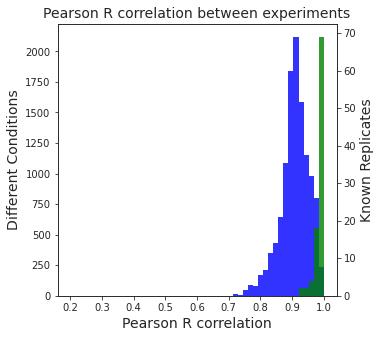

In [19]:
fig,ax = plt.subplots(figsize=(5,5))
ax2 = ax.twinx()
ax2.hist(rep_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='green',linewidth=0)
ax.hist(rand_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='blue',linewidth=0)
ax.set_title('Pearson R correlation between experiments',fontsize=14)
ax.set_xlabel('Pearson R correlation',fontsize=14)
ax.set_ylabel('Different Conditions',fontsize=14)
ax2.set_ylabel('Known Replicates',fontsize=14)

med_corr = np.median([v for k,v in rep_corrs.items()])
print('Median Pearson R between replicates: {:.2f}'.format(med_corr))

Remove samples without any high-correlation replicates

In [20]:
dissimilar = []
for idx, grp in DF_metadata_passed_step4.groupby('full_name'):
    ident = np.identity(len(grp))
    corrs = (DF_log_tpm[grp.index].corr() - ident).max()
    dissimilar.extend(corrs[corrs<rcutoff].index)

# Save this information in both the original metadata dataframe and the new metadata dataframe
DF_metadata_all['passed_replicate_correlations'] = ~DF_metadata_all.index.isin(dissimilar)
DF_metadata_passed_step4['passed_replicate_correlations'] = ~DF_metadata_passed_step4.index.isin(dissimilar)

In [21]:
DF_metadata_final = DF_metadata_passed_step4[DF_metadata_passed_step4['passed_replicate_correlations']]
print('# Samples that passed replicate correlations:',len(DF_metadata_final))

# Samples that passed replicate correlations: 155


In [22]:
DF_metadata_final["project"].value_counts()

Batch_Shaken              48
CO2_oscillation           21
Growth_Variance_W29       14
O2_oscillation_0.05       12
O2_oscillation_0.2        12
O2_oscillation_0.1        12
Growth_Variance_ST8712    12
O2_oscillation            12
O2_oscillation2           12
Name: project, dtype: int64

## Check that reference conditions still exist
If a reference condition was removed due to poor replicate correlations, a new reference condition needs to be defined.

Again, any samples that fail these checks will be printed below.

In [23]:
project_exprs = []
for name,group in DF_metadata_final.groupby('project'):
    
    # Get reference condition
    ref_cond = group.reference_condition.iloc[0]
    
    # Ensure the reference condition is still in the project
    if ref_cond not in group.condition.tolist():
        print('Reference condition missing from:', name)
    
    # Check that each project has at least two conditions (a reference and at least one test condition)
    if len(group.condition.unique()) <= 1:
        print('Only one condition in:', name)

In [24]:
# drop bad projects
bad_projects = ['MIT_splicing', 'ou_aggregate_toxicity']
DF_metadata_final = DF_metadata_final[~DF_metadata_final.project.isin(bad_projects)]

If necessary, choose a new condition for failed projects and re-run notebook.

## Deseq2 Normalization of Counts for Downstream Use

In [25]:
# counts_path = path.join('..', 'data', 'raw_data', 'salmon.merged.gene_counts_length_scaled.tsv')

# DF_counts = pd.read_csv(counts_path, index_col=0, sep='\t').drop('gene_name', axis=1)
# DF_counts = DF_counts[DF_metadata_final.index]
# DF_counts.to_csv(path.join('..', 'data', 'interim', 'counts_data.csv'))
# for index in DF_counts.index: # remove 'gene-' from each gene 
#     DF_counts.rename(index={index:index.strip('gene-')},inplace=True)

In [26]:
# use this cell if you want to decompose on protein-coding genes only (see notebook 0)
# genes = []
# with open('../data/sequence_files/protein_coding_genes.txt', 'r') as genes_file:
#     for line in genes_file:
#         genes.append(line.strip())

# DF_counts = DF_counts.loc[genes]

In [27]:
# normalize the data using pydeseq2's median of ratios method
# from pydeseq2.preprocessing import deseq2_norm

# DF_normalizedCounts = deseq2_norm(DF_counts.T)[0].T

# DF_log_normalizedCounts = DF_normalizedCounts + 1
# DF_log_normalizedCounts = np.log2(DF_log_normalizedCounts)
# DF_log_normalizedCounts

In [28]:
import scipy.cluster.hierarchy as sch
import matplotlib.patches as patches

def global_clustering(data, threshold=0.3, xticklabels=False, yticklabels=False, figsize=(9,9)):
    
    # Retrieve clusters using fcluster 
    corr = data.corr()
    corr.fillna(0,inplace=True)
    dist = sch.distance.pdist(corr)
    link = sch.linkage(dist, method='complete')
    clst = pd.DataFrame(index=data.columns)
    clst['cluster'] = sch.fcluster(link, threshold * dist.max(), 'distance')

    # Get colors for each cluster
    cm = plt.cm.get_cmap('tab20')
    cluster_colors = dict(zip(clst.cluster.unique(), cm.colors + cm.colors))
    clst['color'] = clst.cluster.map(cluster_colors)

    print('Number of cluster: ', len(cluster_colors))
    
    legend_items = [patches.Patch(color=c, label=l) for l,c in cluster_colors.items()]
    
    sns.set(rc={'figure.facecolor':'white'})
    
    clst_map = sns.clustermap(data.corr(), 
                              figsize=figsize, 
                              row_linkage=link, 
                              col_linkage=link, 
                              col_colors=clst.color,
                              yticklabels=yticklabels, 
                              xticklabels=xticklabels,
                              vmin=0, 
                              vmax=1)
    
    legend = clst_map.ax_heatmap.legend(loc='upper left', 
                                        bbox_to_anchor=(1.01,0.85), 
                                        handles=legend_items,
                                        frameon=True)
    
    legend.set_title(title='Clusters',prop={'size':10})
    
    return clst['cluster']

<!-- clusters = global_clustering(DF_log_normalizedCounts) -->

## Normalize dataset to reference conditions

In [29]:
DF_log_tpm_final = DF_log_tpm[DF_metadata_final.index]

In [30]:
# normalize log tpm data
project_exprs = []
for name,group in DF_metadata_final.groupby('project'):
    
    # Get reference condition
    ref_cond = group.reference_condition.iloc[0]
    
    # Get reference condition sample ids
    ref_samples = group[group.condition == ref_cond].index
    
    # Get reference condition expression
    ref_expr = DF_log_tpm_final[ref_samples].mean(axis=1)
    
    # Subtract reference expression from project
    project_exprs.append(DF_log_tpm_final[group.index].sub(ref_expr,axis=0))

DF_log_tpm_norm = pd.concat(project_exprs,axis=1)

In [31]:
# # normalize log normalized counts data to references
# project_exprs = []
# for name,group in DF_metadata_final.groupby('project'):
    
#     # Get reference condition
#     ref_cond = group.reference_condition.iloc[0]
    
#     # Get reference condition sample ids
#     ref_samples = group[group.condition == ref_cond].index
    
#     # Get reference condition expression
#     ref_expr = DF_log_normalizedCounts[ref_samples].mean(axis=1)
    
#     # Subtract reference expression from project
#     project_exprs.append(DF_log_normalizedCounts[group.index].sub(ref_expr,axis=0))

# DF_log_normalizedCounts_norm = pd.concat(project_exprs,axis=1)

In [32]:
# DF_log_normalizedCounts_norm.isna().any().value_counts()

In [33]:
DF_log_tpm_norm.isna().any().value_counts()

False    155
dtype: int64

## Save final datasets

In [34]:
# logTPM_qc_file = path.join('QC_Files','log_tpm.csv')
# logTPM_norm_file = path.join('QC_Files','log_tpm_norm.csv')
# # logNormalizedCounts_qc_file = path.join('data','processed_data','log_normalizedCounts.csv')
# # logNormalizedCounts_norm_file = path.join('data','processed_data','log_normalizedCounts_norm.csv')
# final_metadata_file = path.join('data','processed_data','metadata.tsv')
# final_metadata_all_file = path.join('data','interim','metadata_qc_part2_all.tsv')


# DF_log_tpm_final.to_csv(logTPM_qc_file)
# DF_log_tpm_norm.to_csv(logTPM_norm_file)
# # DF_log_normalizedCounts.to_csv(logNormalizedCounts_qc_file)
# # DF_log_normalizedCounts_norm.to_csv(logNormalizedCounts_norm_file)
# DF_metadata_final.to_csv(final_metadata_file, sep='\t')
# DF_metadata_all.to_csv(final_metadata_all_file, sep='\t')

In [36]:
final_metadata_file = path.join('metadata.tsv')
logTPM_qc_file = path.join('log_tpm.csv')
logTPM_norm_file = path.join('log_tpm_norm.csv')

DF_metadata_final.to_csv(final_metadata_file, sep='\t')
DF_log_tpm_final.to_csv(logTPM_qc_file)
DF_log_tpm_norm.to_csv(logTPM_norm_file)